<a href="https://colab.research.google.com/github/baroodb/code/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path
import matplotlib.pyplot as plt



In [26]:
# CONSTANT
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 10

In [3]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file(fname='cats_and_dogs.zip', origin=url, extract=True)

68616192/68606236 [==============================] - 1s 0us/step


In [4]:
base_dir = os.path.dirname(path_to_zip)
os.listdir(base_dir)

['cats_and_dogs.zip', 'cats_and_dogs_filtered']

In [5]:
img_dir = os.path.join(base_dir, 'cats_and_dogs_filtered')
print(img_dir)

/root/.keras/datasets/cats_and_dogs_filtered


In [6]:
# we check the content of the img_folder
os.listdir(img_dir)
train_dir = os.path.join(img_dir, 'train')
val_dir = os.path.join(img_dir, 'validation')

In [7]:
os.listdir(val_dir)

['dogs', 'cats']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                               seed=123, 
                                                               image_size=IMG_SIZE, 
                                                               batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                               seed=123, 
                                                               image_size=IMG_SIZE, 
                                                               batch_size=BATCH_SIZE)

Found 1000 files belonging to 2 classes.


In [10]:
# class names
class_names = train_ds.class_names
class_names

['cats', 'dogs']

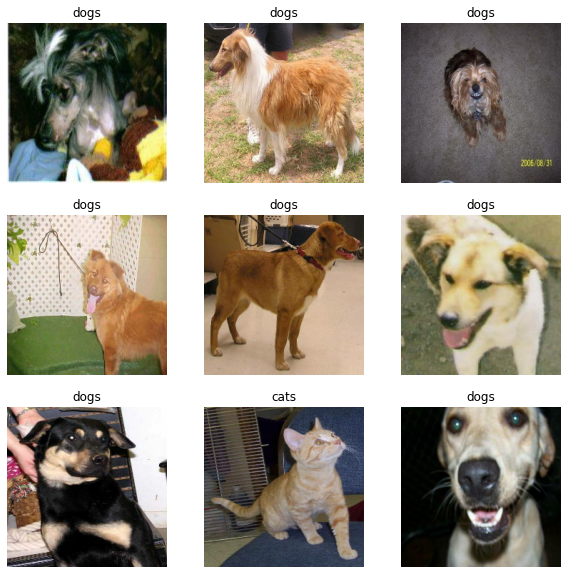

In [11]:
# lets plot some images from the training images 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('OFF')

In [12]:
# Dealing with  the cardinality 
val_batches = tf.data.experimental.cardinality(val_ds)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [13]:
train_batches = tf.data.experimental.cardinality(train_ds)
train_batches

<tf.Tensor: shape=(), dtype=int64, numpy=63>

In [14]:
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [15]:
# print the  final cardinalities
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(63, shape=(), dtype=int64)
tf.Tensor(26, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)


In [16]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# build the  data augmentation layer
aug = tf.keras.Sequential([
                           tf.keras.layers.experimental.preprocessing.RandomFlip(),
                           tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

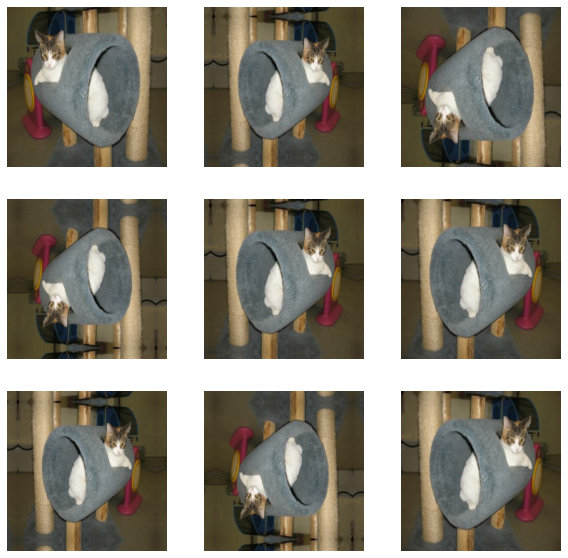

In [18]:
#
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = aug(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [19]:
# think about the model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [20]:
base_model = tf.keras.applications.MobileNetV2(include_top=False)

# freeze all the  layers 
base_model.trainable = False

layers = [layer for layer in base_model.layers]
print(len(layers))

9420800/9406464 [==============================] - 0s 0us/step
154


In [21]:
IMG_SIZE+(3,)

(224, 224, 3)

In [22]:
# building the mdoel 
inputs = Input(shape=IMG_SIZE+(3,))
x = aug(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

lrate = 1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [23]:
#lets evaluate the model before training 
model.evaluate(val_ds)

26/26 [==============================] - 31s 97ms/step - loss: 0.5769 - accuracy: 0.7017


[0.5768667459487915, 0.7017326951026917]

In [27]:
H = model.fit(train_ds, 
              validation_data=val_ds, 
              epochs=EPOCHS)

Epoch 1/10
63/63 [==============================] - 8s 121ms/step - loss: 0.3495 - accuracy: 0.8435 - val_loss: 0.2280 - val_accuracy: 0.8923
Epoch 2/10
63/63 [==============================] - 8s 121ms/step - loss: 0.3041 - accuracy: 0.8665 - val_loss: 0.1975 - val_accuracy: 0.9047
Epoch 3/10
63/63 [==============================] - 8s 121ms/step - loss: 0.2841 - accuracy: 0.8760 - val_loss: 0.1748 - val_accuracy: 0.9208
Epoch 4/10
63/63 [==============================] - 8s 122ms/step - loss: 0.2671 - accuracy: 0.8830 - val_loss: 0.1549 - val_accuracy: 0.9406
Epoch 5/10
63/63 [==============================] - 8s 120ms/step - loss: 0.2461 - accuracy: 0.8975 - val_loss: 0.1422 - val_accuracy: 0.9480
Epoch 6/10
63/63 [==============================] - 8s 120ms/step - loss: 0.2339 - accuracy: 0.8945 - val_loss: 0.1296 - val_accuracy: 0.9554
Epoch 7/10
63/63 [==============================] - 8s 120ms/step - loss: 0.2185 - accuracy: 0.9055 - val_loss: 0.1211 - val_accuracy: 0.9579
Epoch 